In [345]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.io import *
from fastai.conv_learner import *
from fastai.column_image_data import *
from PIL import Image
from matplotlib import animation, rc
from IPython.display import HTML
from skimage.measure import block_reduce
import time
from IPython.display import clear_output
from torchvision import transforms


PATH='D:\\Code\\kural_work\\movie_generation\\data\\'
movie_name = 's01_5m_2s_100ms_25p.tif'
img_ = Image.open(PATH+movie_name)
nf = img_.n_frames #number of frames
img = []

width = 128
top = [80+86*i for i in range(3)] 
left = [90+86*i for i in range(3)] 
for t in top:
    for l in left:
        for i in range(nf):
            img_.seek(i)
            img.append(np.asarray(list(img_.getdata())).reshape(512,512)[t:t+width,l:l+width])
            cur_img = img[-1]
            for k in range(1,4):
                img.append(np.rot90(cur_img,k=k))
            img.append(cur_img.T)
            cur_img = img[-1]
            for k in range(1,4):
                img.append(np.rot90(cur_img,k=k))

img = np.stack(img)
img = torch.from_numpy(np.ascontiguousarray(img)).float()
img = (img-img.min().item())/(img.max().item()-img.min().item())
img = img.view(nf*3*3*8,1,width,width)
kernel_size = 8
img = nn.MaxPool2d(kernel_size)(img)
img = img.view(nf*3*3*8,width**2//kernel_size**2)
img = img.cuda()

In [346]:
class ImageDataset(Dataset):
    def __init__(self, img, num_imgs=1, transform=None):
        self.img = img
        self.transform = transform
        self.num_imgs = num_imgs
    
    def __len__(self):
        return self.img.shape[0]
    
    def __getitem__(self,i):
        nf = self.img.shape[0]
        idx = random.choice(range(nf))
        img = self.img[idx,:,:]
        if self.transform:
            img = self.transform(img)
        return img
        

In [347]:
class RandomCropRotateMirror(object):
    """
    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, img):
        h, w = img.shape
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        img = img[top:  top  + new_h,
                  left: left + new_w]    
        
        return img[None,:,:]
        
    
class MaxPoolAndFlatten(object):
    def __init__(self,kernel_size):
        self.ks = kernel_size
    def __call__(self, img):
        img = nn.MaxPool2d(self.ks)(img)
        return img.view(1,-1)

In [4]:
crop_size = 128
pool_kernel = 8
ds = ImageDataset(img,10000,transform=transforms.Compose([
                                               RandomCropRotateMirror(crop_size),
                                               MaxPoolAndFlatten(pool_kernel)]))

dl = torch.utils.data.DataLoader(ds,batch_size=500)

In [348]:
ds = torch.utils.data.TensorDataset(img)
dl = torch.utils.data.DataLoader(ds,batch_size=500, shuffle=True)

In [349]:
class AutoencoderModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, cell_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size,hidden_size1)
        self.fc2 = nn.Linear(hidden_size1,hidden_size2)
        self.fc3 = nn.Linear(hidden_size2,cell_size)
        self.fc3r = nn.Linear(cell_size,hidden_size2)
        self.fc2r = nn.Linear(hidden_size2,hidden_size1)
        self.fc1r = nn.Linear(hidden_size1,input_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc3r(x))
        x = F.relu(self.fc2r(x))
        x = torch.clamp(self.fc1r(x),0,1)
        

        return x

In [99]:
from line_profiler import LineProfiler

def do_profile(follow=[]):
    def inner(func):
        def profiled_func(*args,**kwargs):
            try:
                profiler = LineProfiler()
                profiler.add_function(func)
                for f in follow:
                    profiler.add_module(f)
                profiler.enable_by_count()
                return func(*args,**kwargs)
            finally:
                profiler.print_stats()
        return profiled_func
    return inner

In [350]:
# @do_profile(follow=[ImageDataset,RandomCropRotateMirror,MaxPoolAndFlatten])
# def profile_fit():
loss_list = []
model = AutoencoderModel(16*16,128,64,32).cuda()
criterion = nn.MSELoss()
per_epoch = len(dl)
num_write_out = 3
write_out_point = np.ceil(per_epoch/num_write_out)

In [351]:
cycles = 1000
epochs = 10

for _ in range(cycles):
    lr = 1e-3
    for epoch in range(epochs):
        opt = optim.Adam(model.parameters(), lr = lr)
        lr /= np.sqrt(10)
        running_loss = 0.0
        for i, data, in enumerate(dl):
            opt.zero_grad()
            y_pred = model(data[0])
            loss = criterion(y_pred,data[0])
            loss.backward()
            opt.step()
#             running_loss += loss.item()
            loss_list.append(loss.item())
#             if i%write_out_point == write_out_point-1:
#                 print(f'[{epoch+1}, {i+1}] loss: {running_loss/num_write_out}')
#                 running_loss = 0.0
#     return model, loss_list

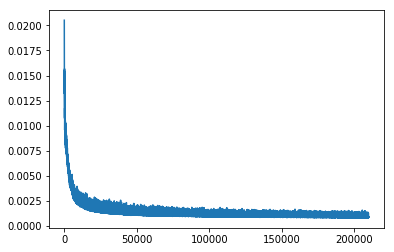

In [352]:
plt.plot(loss_list)
# plt.ylim((0.035, .05))

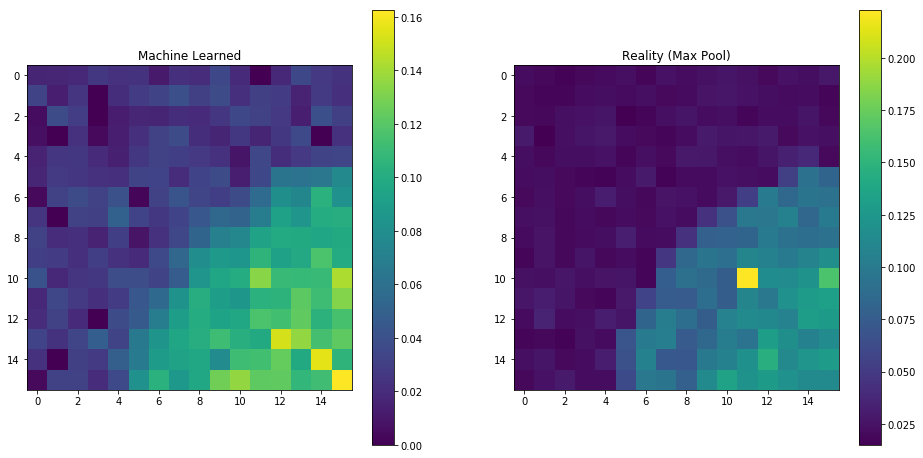

In [360]:
idx = np.random.choice(range(9000,len(ds)))
x, = ds[idx]

y_pred = model(x)
# plt.figure()
fig, ax = plt.subplots(1,2,figsize=(16,8))
im0 = ax[0].imshow(y_pred.cpu().data.view(16,16))
ax[0].set_title('Machine Learned')
im1 = ax[1].imshow(x.cpu().data.view(16,16))
ax[1].set_title('Reality (Max Pool)')
plt.colorbar(mappable=im0,ax=ax[0])
plt.colorbar(mappable=im1,ax=ax[1])
plt.show()

In [208]:
pwd

'C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work'

In [209]:
torch.save(model,'C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\whole_model.pth')

C:\Users\joshu\Miniconda3\envs\fastai\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type AutoencoderModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [361]:
torch.save(model.state_dict(),'C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\state_dict_new.pth')

In [198]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0442,  0.0300, -0.0472,  ...,  0.0158, -0.0755,  0.1008],
                      [ 0.0807,  0.1801,  0.0210,  ..., -0.0726,  0.0094,  0.1045],
                      [ 0.1386,  0.0011, -0.0480,  ...,  0.0391,  0.1562,  0.1961],
                      ...,
                      [ 0.2095,  0.0277,  0.0283,  ...,  0.0103, -0.1637, -0.1448],
                      [ 0.0694,  0.0871, -0.0661,  ..., -0.1319, -0.1207, -0.0784],
                      [-0.0553, -0.0317,  0.0418,  ...,  0.0551, -0.0578, -0.0677]],
                     device='cuda:0')),
             ('fc1.bias',
              tensor([-0.0636, -0.0737, -0.0144, -0.0257, -0.0951, -0.0884,  0.0010, -0.0420,
                      -0.0229, -0.0931, -0.0094, -0.0404, -0.0049, -0.0518, -0.0554, -0.0453,
                       0.0755, -0.0097, -0.0029, -0.0932, -0.0530, -0.1712,  0.0672, -0.0395,
                      -0.0368, -0.0593, -0.0553,  0.0365, -0.0406, -0.0653,  0.0325, -0.0351

In [201]:
opt.state_dict()['param_groups']

[{'lr': 3.162277660168377e-08,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'params': [2983180290376,
   2983176686832,
   2983180289152,
   2983490478512,
   2983019072392,
   2983019073256,
   2983019071168,
   2984624521936,
   2984624524888,
   2983176833712,
   2983176831336,
   2983176832776]}]

In [44]:
%load_ext line_profiler

In [337]:
class EncryptionModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, cell_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size,hidden_size1)
        self.fc2 = nn.Linear(hidden_size1,hidden_size2)
        self.fc3 = nn.Linear(hidden_size2,cell_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [338]:
emodel = EncryptionModel(*[32*2**i for i in range(3,-1,-1)])

In [339]:
sd_path = 'C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\state_dict.pth'
for key, value in torch.load(sd_path).items():
    layer, worb = key.split('.')
    if layer in dir(emodel):
        setattr(getattr(getattr(emodel,layer),worb),'data',value)

In [340]:
emod_out = emodel(img)

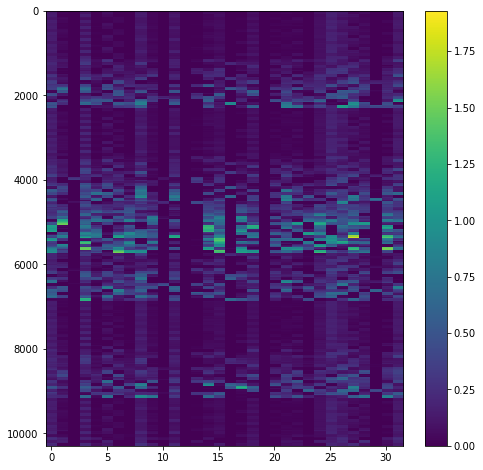

In [341]:
plt.figure(figsize = [8,8])
plt.imshow(emod_out.data.cpu().numpy())
_ = plt.axis('tight')
plt.colorbar()

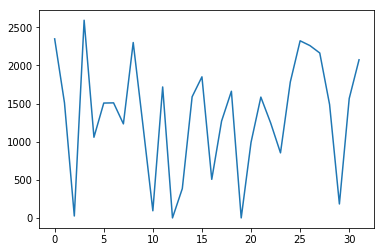

In [343]:
plt.plot(torch.sum(emod_out,dim=0).data.cpu().numpy())

C:\Users\joshu\Miniconda3\envs\fastai\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


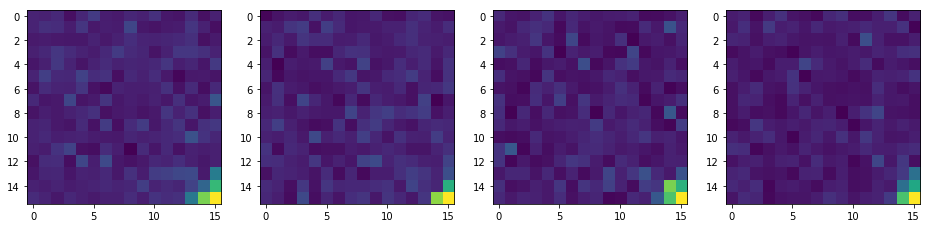

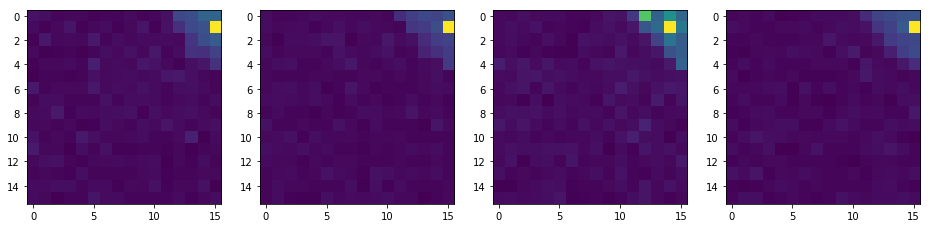

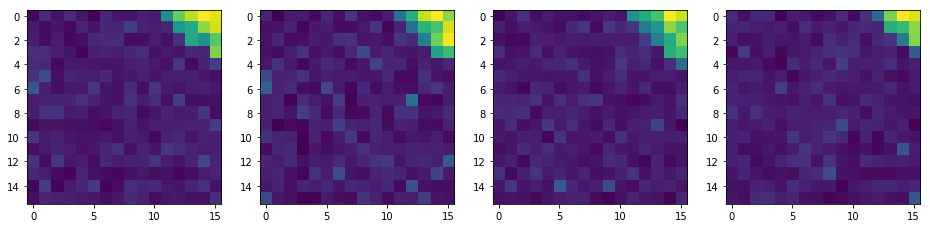

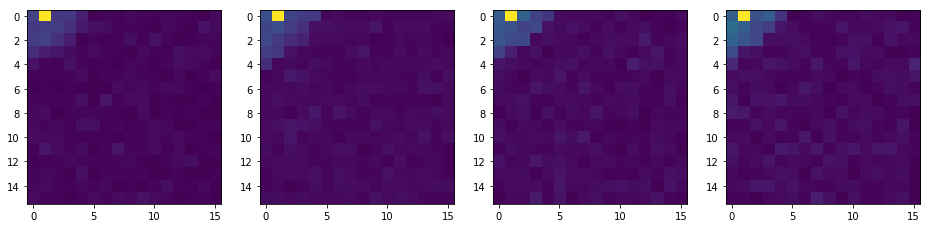

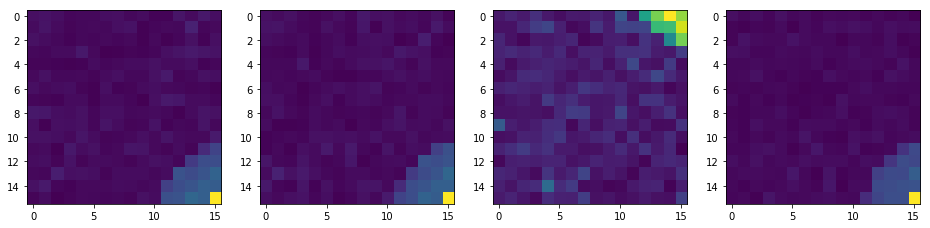

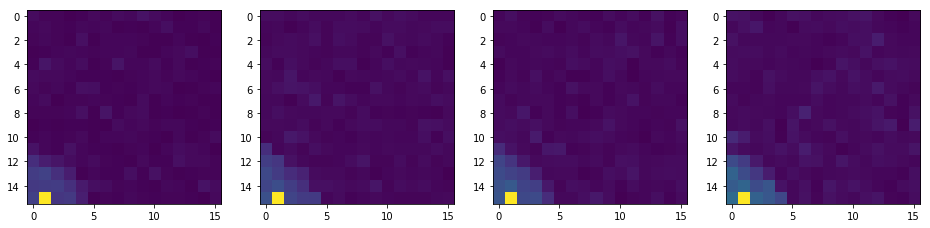

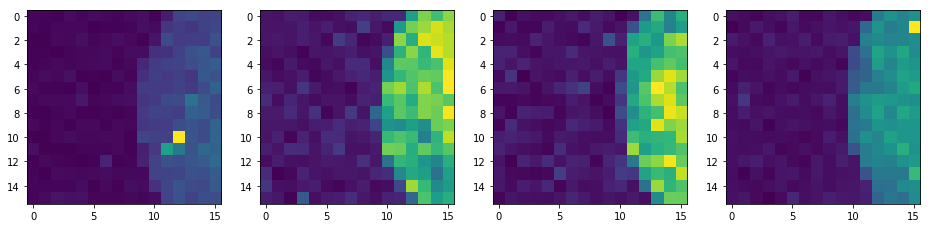

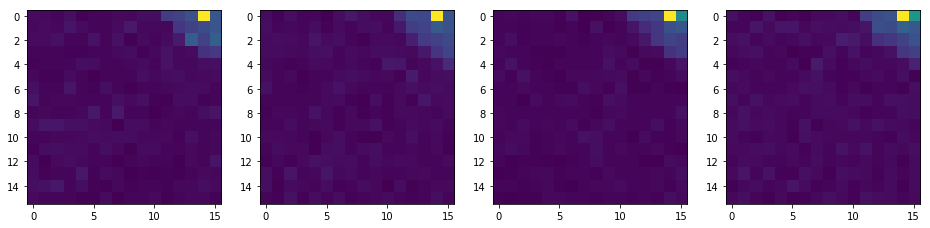

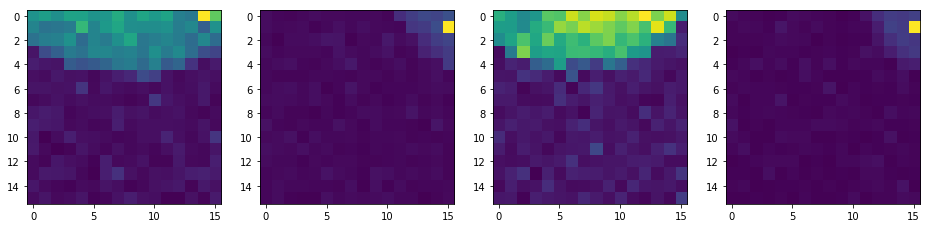

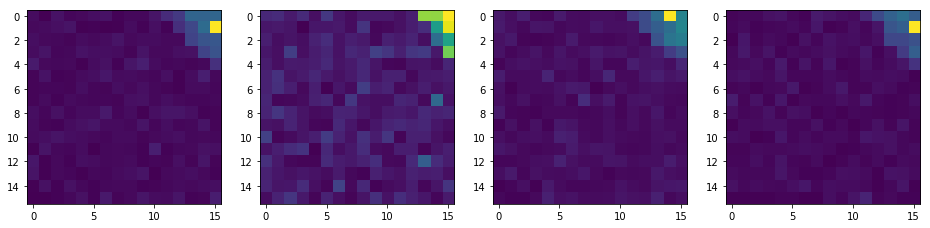

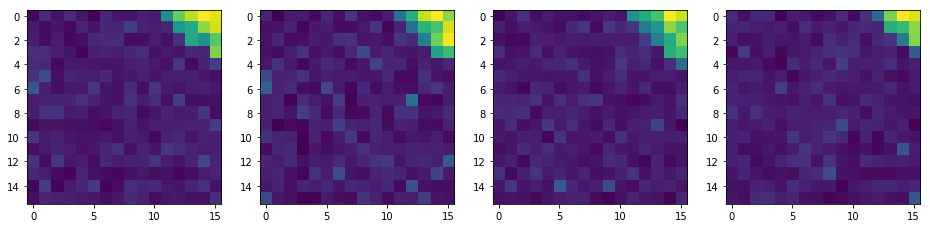

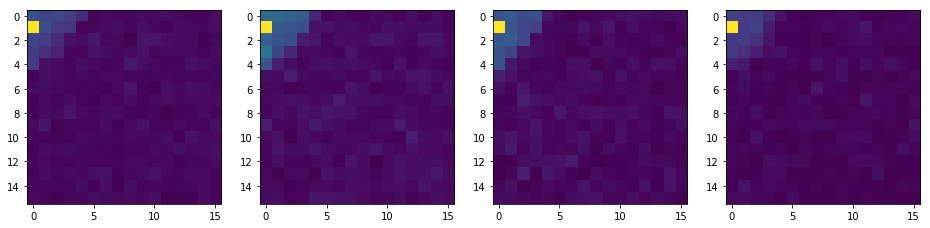

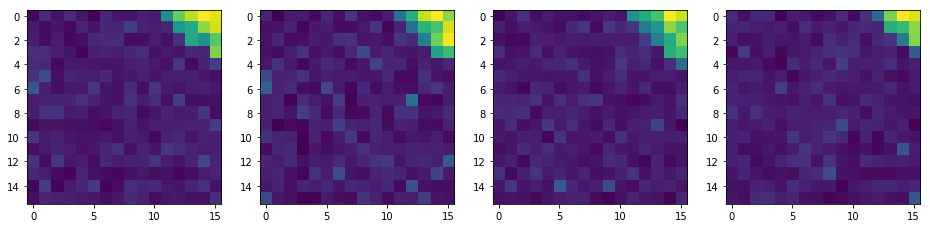

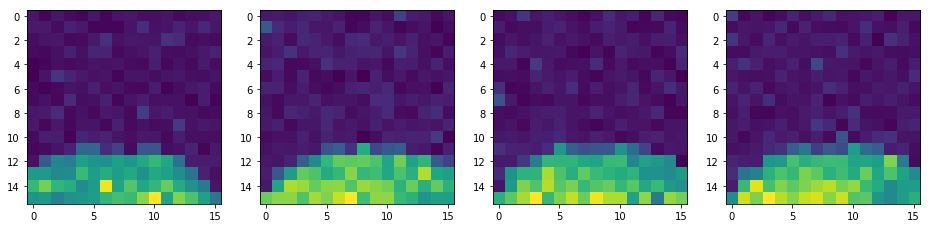

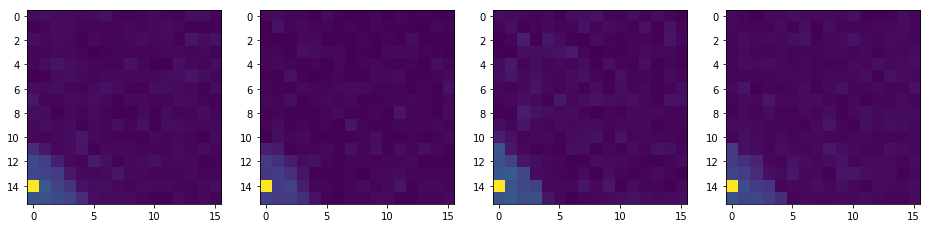

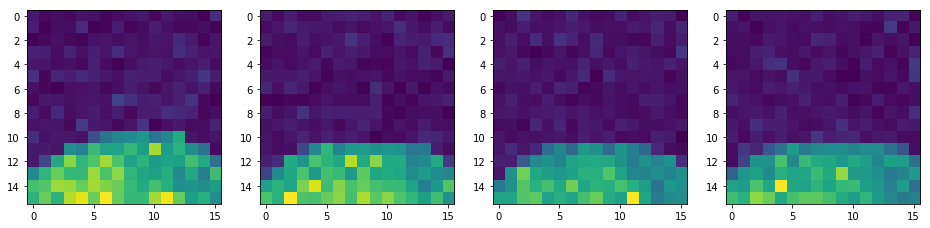

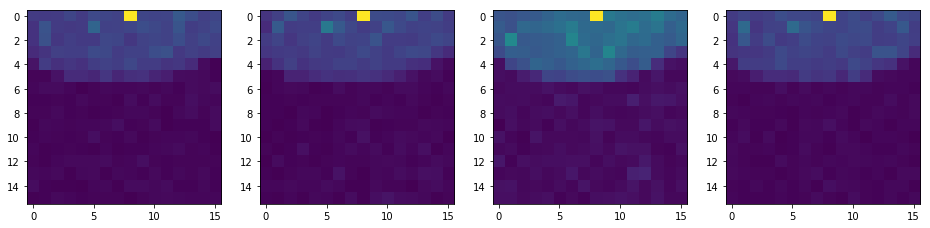

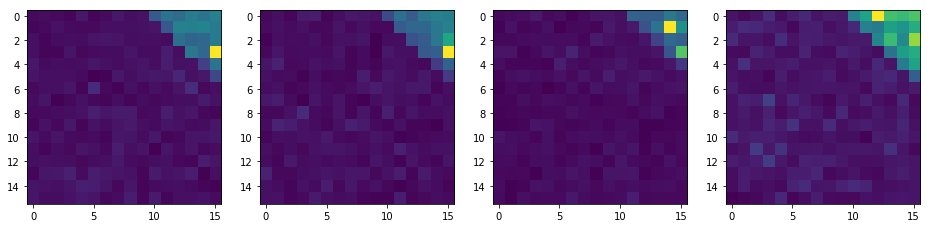

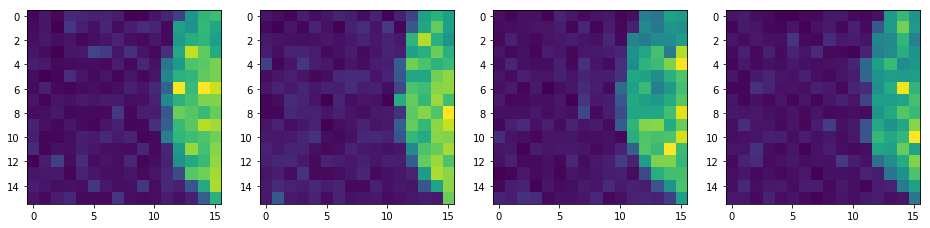

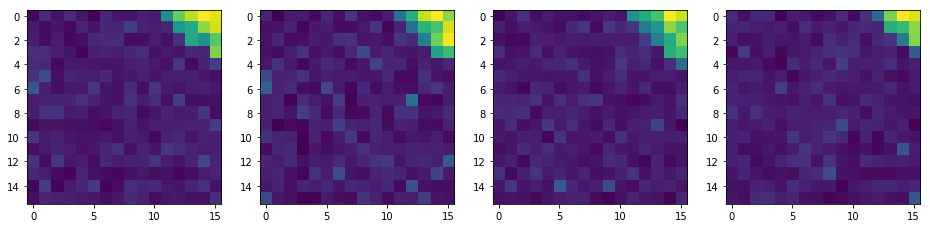

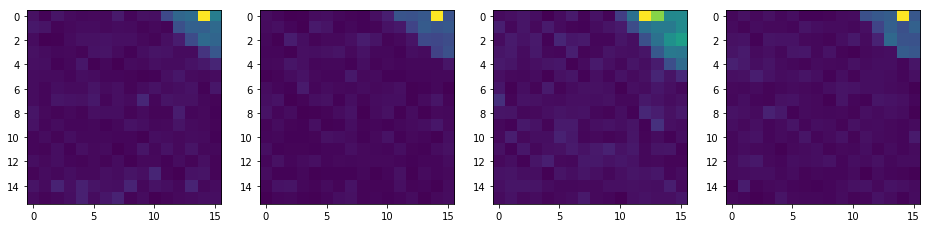

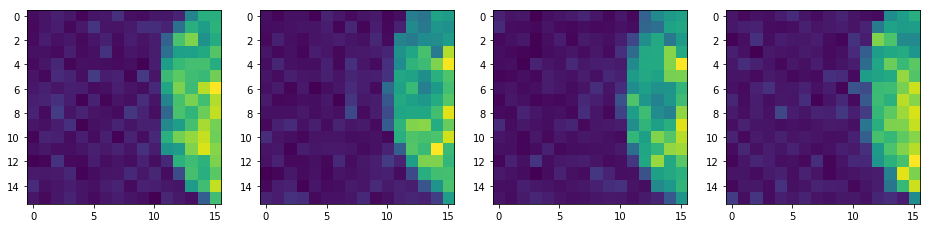

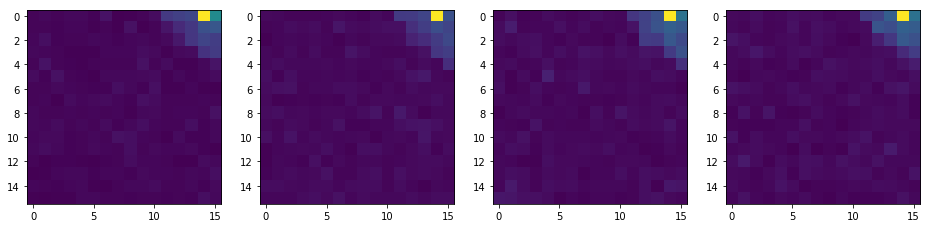

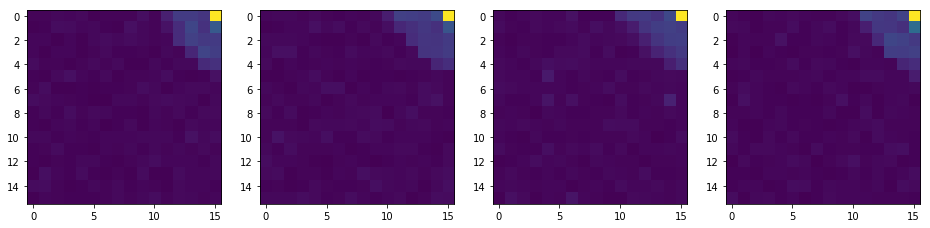

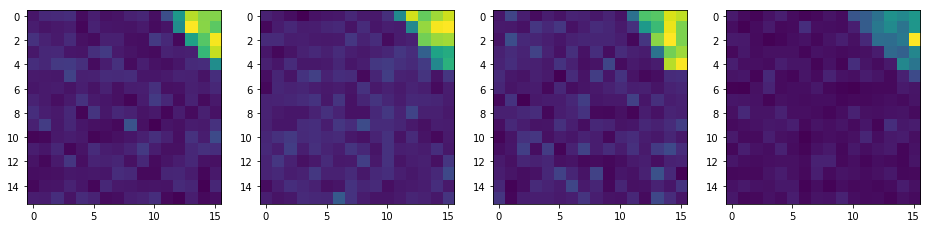

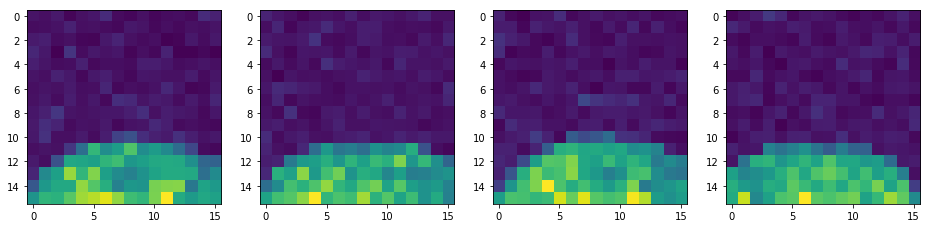

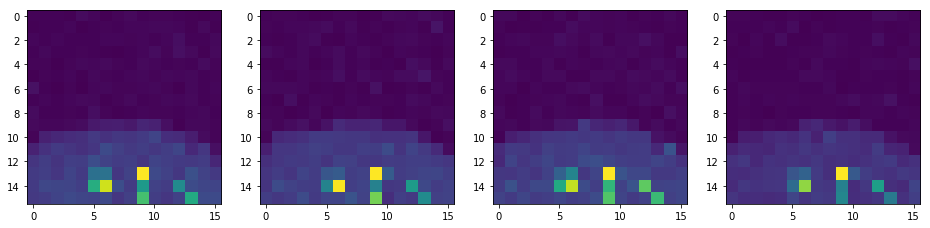

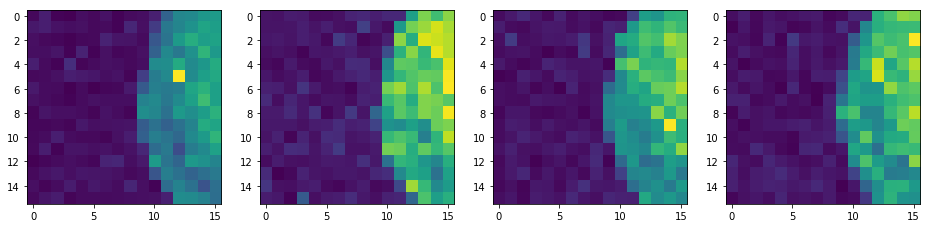

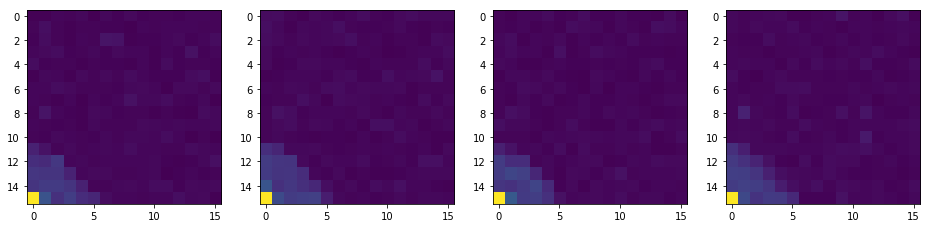

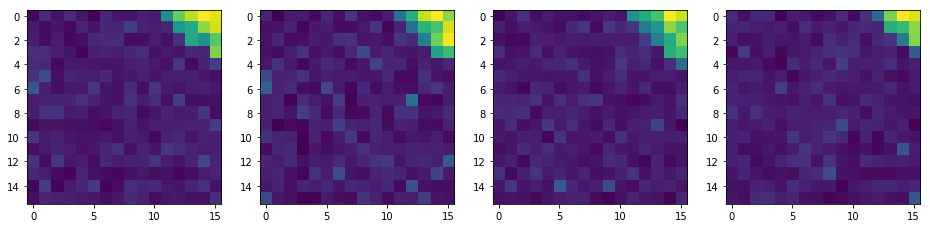

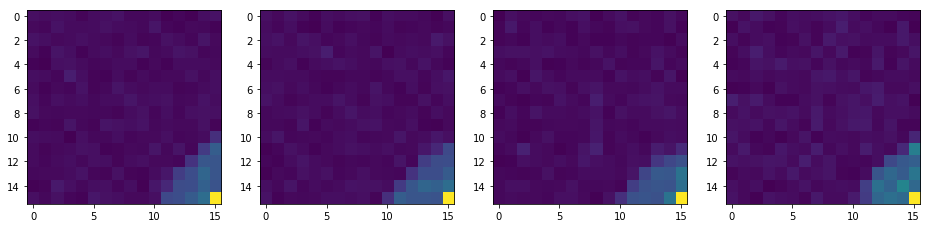

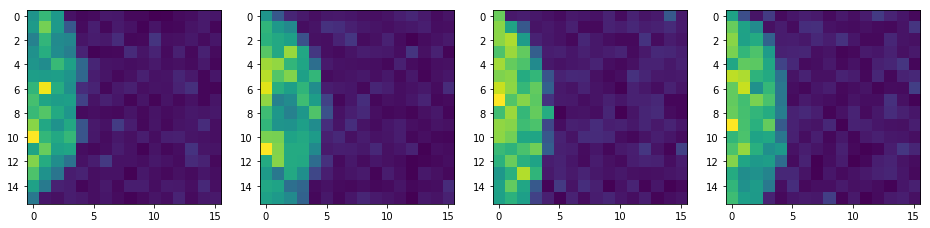

In [344]:
for i in range(32):
    activates = torch.zeros(1,32, device=torch.device('cuda'))
    activates[0,i] = 1
    out = torch.sum((emodel(img)-activates)**2,dim=1)

    args = np.argsort(out.data.cpu().numpy())

    fig, ax = plt.subplots(1,4, figsize = [16,4])
    for i in range(4):
        ax[i].imshow(img[args[i]].view(16,16).data.cpu().numpy())

In [324]:
args

array([4715, 4723, 4675, ..., 5651, 5699, 5715], dtype=int64)